In [1]:
%load_ext autoreload
%autoreload 2

## Evaluate QSO Selection Completeness For Simulated Cadences

**Last Run:** 02/24/21
</br> __Description:__ This notebook evaluates the QSO selection completeness metric defined [here](./07_AGNColorSelect.ipynb) on multiple cadence simulations

### 0. Software Setup

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import numpy as np
import glob
import os

In [3]:
# automatically extract username
your_username = os.getcwd().split('/')[5]
print(f'Your automatically extracted username is: {your_username}.'
        '\nIf it is incorrect, please mannually reset it.')

Your automatically extracted username is: ywx649999311.
If it is incorrect, please mannually reset it.



##### Import the sims_maf modules needed.

In [4]:
# import lsst.sim.maf moduels modules
import lsst.sims.maf.db as db
import lsst.sims.maf.metrics as metrics
import lsst.sims.maf.slicers as slicers
import lsst.sims.maf.stackers as stackers
from lsst.sims.maf.stackers import BaseStacker
import lsst.sims.maf.plots as plots
import lsst.sims.maf.metricBundles as metricBundles

# import convenience functions
from opsimUtils import *

### 1. Define the Metric

In [5]:
from lsst.sims.maf.metrics import BaseMetric
from lsst.sims.maf.metrics import Coaddm5Metric
import healpy as hp

class color_selection_function(BaseMetric):
    """Selection Fucntion Metricz: Evaluate compleness given selection criteria"""
    
    def __init__(self, qso_df, z_low, z_high, query, sim_y_limit=28.0, passbands=['u', 'g', 'r', 'i', 'z', 'y'], 
                 coaddm5Metric = Coaddm5Metric, m5Col="fiveSigmaDepth", metricDtype=None, **kwargs):

        """Init function.
        
        Args:
            qso_df(object): Pandas dataframe of simulated QSOs.
            z_low(float): The lower limit of the redshift range for the corresponding
                selection criteria.
            z_high(float): The upper limit of the redshift range for the corresponding
                selection criteria.
            query(str): The query for the selection criteria.
            sim_y_limit(float): The y-band depth of the simulated QSOs, i.e., only simulated QSOs that 
                are brighter than sim_y_limit will be used to determine this selection metric. 
                Defaluts to 28.0.
            passbands(object): A list passbands will be needed to for selection. Please 
                make sure to specify all bands needed, otherwise error might occur. Defaults to all.
            coaddm5Metric(object): The metric class for computing coadded 5-sigma limiting magnitude. 
                Defaluts to the norminal CoaddM5Metric. 
            m5Col(str): The column name for the 5-sigma limiting magnitude column. Defaluts to 
                "fiveSigmaDepth".
            metricDtype(str): The data type of the returned metric -- "int", "float" or "object". 
                Set it to "object" if returning an array. Defaults to None (determined by MAF). 
        """
        
        self.qso_df = qso_df
        self.z_low = z_low
        self.z_high = z_high
        self.query = query
        self.sim_y_limit = sim_y_limit
        self.passbands = passbands
        self.m5Col = m5Col
        self.filterCol = 'filter'
        self.metricName = f'color_select_{z_low}_{z_high}_Y{sim_y_limit}' # metricName by redshift range
        self.coaddm5Metric = coaddm5Metric(m5Col=self.m5Col)
        
        cols=[self.m5Col, self.filterCol]
        super(color_selection_function, self).__init__(col=cols, metricDtype=metricDtype, metricName=self.metricName, **kwargs)

    
    def run(self, dataSlice, slicePoint=None):
        """
        Test the high-z color cut from Banados 2016 to select 5.7 < z < 6.5 quasars

        :param dataSlice:
        :return:
        
        """
        
        # placeholder for 5-sigma limiting magnitude (m5), will be computed below
        m5 = {} 
        # select simulated QSOs in the provided redshift/magnitude range
        first_cut = f'({self.z_low} < z < {self.z_high}) and (LSST_Wide_y_mag < {self.sim_y_limit})'
        df_qso = self.qso_df.query(first_cut).copy('deep').reset_index(drop=True)
        
        # loop over each passband in the passbands
        for passband in self.passbands:

            # mask this pixel as bad if zero visit found in any passband
            if dataSlice[dataSlice['filter'] == passband].size < 1:
                return self.badval
            
            # compute 5 sigma limiting depth
            m5[passband] = self.coaddm5Metric.run(dataSlice[dataSlice['filter'] == passband])
            
            # create new column to store the m5 mag
            df_qso.loc[:, f'LSST_Wide_{passband}_mag_5sigma'] =  m5[passband]
            
            # subtitute simulated mag with m5depth if mag > m5depth;
            # e.g., If simulated qso has a y-band mag of 26 and the m5coadd mag in y-band is 24, 
            # the y-band mag will be replaced with 24;
            # We make this update based-on color selection criteria
            df_qso.loc[:, f'LSST_Wide_{passband}_mag_lsst'] = df_qso.loc[:, f'LSST_Wide_{passband}_mag']
            df_qso[f'LSST_Wide_{passband}_mag_lsst'].where(
                (df_qso[f'LSST_Wide_{passband}_mag_lsst'] <= m5[passband]), m5[passband], inplace=True)

#             idx = df_qso.query(f'LSST_Wide_{passband}_mag >= {m5[passband]}').index
#             df_qso.loc[idx, f'LSST_Wide_{passband}_mag_lsst'] = m5[passband]
            
        # Quasar selection color cut; criteria provided by user
        # e.g., self.query could be:
        # '(LSST_Wide_i_mag - LSST_Wide_z_mag > 2) and (LSST_Wide_z_mag - LSST_Wide_y_mag < 0.5)'
        sel = df_qso.query(self.query)
                
        # get the number of selected QSOs by given criteria 
        # and the total number in the specific redshift range
        n_qso_sel = np.int(sel.shape[0])
        n_qso = np.int(df_qso.shape[0])
        
        return n_qso_sel/n_qso

### 2. Run on 20 selected Cadence Simulations from FBS_v1.5
#### 2.1 Setup connection to the simulation databases

In [6]:
if your_username == '': # do NOT put your username here, put it in the cell at the top of the notebook.
    raise Exception('Please provide your username!  See the top of the notebook.')

dbDir = '/home/idies/workspace/lsst_cadence/FBS_1.5/'
outDir = f'/home/idies/workspace/Temporary/{your_username}/LSST_MAF/wy/Class/022321/ResultDBs/'
metricDataPath = f'/home/idies/workspace/Temporary/{your_username}/LSST_MAF/wy/Class/022321/MetricData/'

if not os.path.exists(os.path.abspath(outDir)):
    os.makedirs(os.path.abspath(outDir))
    
if not os.path.exists(os.path.abspath(metricDataPath)):
    os.makedirs(os.path.abspath(metricDataPath))

In [7]:
dbRuns = show_opsims(dbDir)
dbRuns[0:5] # only show first 5 opsims

['dcr_nham1_ugri_v1.5_10yrs',
 'rolling_mod6_sdf_0.20_v1.5_10yrs',
 'wfd_depth_scale0.95_noddf_v1.5_10yrs',
 'u60_v1.5_10yrs',
 'footprint_stuck_rollingv1.5_10yrs']

#### 2.2 Select one OpSim from each family

Where family is indicated by the first part (before the 1st underscore) of the DB file name

In [8]:
dbFamil = [run.split('_')[0] for run in dbRuns]
dfRuns = pd.DataFrame({'run':dbRuns, \
                       'runFamil':dbFamil}).sort_values(by='runFamil').reset_index(drop=True)
dfRuns.head()

,run,runFamil
0,agnddf_v1.5_10yrs,agnddf
1,alt_dust_v1.5_10yrs,alt
2,alt_roll_mod2_dust_sdf_0.20_v1.5_10yrs,alt
3,baseline_samefilt_v1.5_10yrs,baseline
4,baseline_v1.5_10yrs,baseline


In [9]:
# pick one run from each family
dfRunPick = dfRuns.drop_duplicates(subset=['runFamil']).reset_index(drop=True)
dfRunPick

,run,runFamil
0,agnddf_v1.5_10yrs,agnddf
1,alt_dust_v1.5_10yrs,alt
2,baseline_samefilt_v1.5_10yrs,baseline
3,bulges_cadence_bs_v1.5_10yrs,bulges
4,daily_ddf_v1.5_10yrs,daily
5,dcr_nham1_ug_v1.5_10yrs,dcr
6,descddf_v1.5_10yrs,descddf
7,filterdist_indx5_v1.5_10yrs,filterdist
8,footprint_no_gp_northv1.5_10yrs,footprint
9,goodseeing_gri_v1.5_10yrs,goodseeing


If you want to run all the runs, use "dfRuns".  If you are happy just looking at an example from each family, then use "dfRunPick" below.

In [10]:
# two dictionary are returned by the following function, 
# One (opSimDbs) is a dictionary storing all database objects
# Another (resultDbs) is a dictionary consist of the objects directing MAF where to save metric metadata
# Both dictionaries are indexed by OpSim run names
opSimDbs, resultDbs = connect_dbs(dbDir, outDir, dbRuns=dfRunPick.run.values)

#### 2.3 Run 'color_selection_function' metric (and coaddm5 in y-band) on those selected cadence simulations
We use `joblib` to parallel this process

Install with:
> !pip install joblib

In [11]:
# import dask and create client
from joblib import Parallel, delayed

##### 2.3.1 Color_Selection Metric

In [12]:
# load simulated QSOs
sim_path = '/home/idies/workspace/lsst_cadence/LSST_AGN/Class/Data/selsing2016_photo_Shen_qlf_1000sdeg_z5to7_y14to28_LSST_models.hdf5'
qso_df = pd.read_hdf(sim_path)


# LSST_Wide_{band}_mag_lsst are magnitudes adjusted to LSST depth, use this for selection.
# LSST_Wide_{band}_mag are the true magnitudes of the simulated QSOs, use this for determining dropout.
# color selection criteria from Banados 2016 for 5.7 < z < 6.5.
color_select_query = '(LSST_Wide_i_mag_lsst - LSST_Wide_z_mag_lsst > 2) and ' + \
                     '(LSST_Wide_z_mag_lsst - LSST_Wide_y_mag_lsst < 0.5) and' + \
                     '(LSST_Wide_u_mag > LSST_Wide_u_mag_5sigma) and ' + \
                     '(LSST_Wide_g_mag > LSST_Wide_g_mag_5sigma) and ' + \
                     '(LSST_Wide_r_mag > LSST_Wide_r_mag_5sigma)'

# create metric object
selection_metric = color_selection_function(qso_df, 5.7, 6.5, color_select_query)

# slicer = a grouping or subdivision of visits for the simulated survey
# based on their position on the sky (using a Healpix grid)
slicer = slicers.HealpixSlicer(nside=32)

# constraint = the sql query (or 'select') that selects all visits in r band
constraint = 'proposalId = 1'
constraint += ' and note not like "DD%"'

# create metric bundle to group metric, slicer and sql constraint together
selection_mb = metricBundles.MetricBundle(selection_metric, slicer, constraint)

Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes


##### 2.2.2 Y-band CoaddMetric 

In [13]:
coaddYMetric = metrics.Coaddm5Metric()

# constraint = the sql query (or 'select') that selects all visits in r band
coaddYconstraint = 'proposalId = 1'
coaddYconstraint += ' and note not like "DD%"'
coaddYconstraint += ' and filter = "y"'

coaddY_mb = metricBundles.MetricBundle(coaddYMetric, slicer, coaddYconstraint)

In [14]:
# put bundle into bundle dict
bundleDict = {selection_mb.metric.name: selection_mb, coaddY_mb.metric.name: coaddY_mb}

# set summary metrics
summaryMetrics = [metrics.PercentileMetric(percentile=10), metrics.MedianMetric(),
                  metrics.PercentileMetric(percentile=90)]
for mb in bundleDict:
    bundleDict[mb].setSummaryMetrics(summaryMetrics)

In [ ]:
# define function to run MAF on one opsim which is easily parallelziable. 
def run_mg(run, bundleDict, dbDir, outDir, metricDataPath):
    """
    Function to run pre-defined MAF metrics on one OpSim. 
    
    Args:
        run (str): The OpSim cadence run name.
        bundleDict (dict): A dictionary of MAF metrics.
        dbDir (str): The path to the OpSim databases.
        outDir (str): The path to the resultdb databases.
        metricDataPath (str): The path to the actual metric data (.npz files). 
    """
    rt = ''
    try:
        for key in bundleDict:
            bundleDict[key].setRunName(run)

        # init connection given run name
        opSimDb, resultDb = connect_dbs(dbDir, outDir, dbRuns=[run])
        # make a group
        metricGroup = metricBundles.MetricBundleGroup(bundleDict, opSimDb[run], 
                                                      metricDataPath, 
                                                      resultDb[run], verbose=False)
        metricGroup.runAll()
    
        # close sql db
        opSimDb[run].close()
        resultDb[run].close()
        
    except Exception as e:
        print(f'{run} failed!')
        print(e)
        print('----------------------')
        rt = run
            
    return rt

# placeholder for joblib returned result
rt = []
rt = Parallel(n_jobs=14)(delayed(run_mg)(run, bundleDict, dbDir, outDir, metricDataPath) 
                         for run in dfRunPick.run.values)

# check failed 
failed_runs = [x for x in rt if len(x) > 0]

### 3. Take a peek at the distribution of the metrics
#### 3.1 Import metric data & Check metricBundle keys

In [18]:
# import metric evaluations
bundleDicts = {}
resultDbPath = outDir

resultDbsView = getResultsDbs(resultDbPath)
for runName in resultDbsView:
    bundleDicts[runName] = bundleDictFromDisk(resultDbsView[runName], runName, metricDataPath)

Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slic

In [19]:
# Check keys
dbRuns = list(resultDbsView.keys())
bd_keys = list(bundleDicts[dbRuns[1]].keys())
print(bd_keys)

[(1, 'CoaddM5'), (2, 'color_select_5.7_6.5_Y28.0')]


#### 3.2 Histograms

In [20]:
# return median metric data
def get_median(mb):
    
    mask = mb.metricValues.mask
    data = mb.metricValues.data[~mask]
    data = data[~(np.isnan(data) | np.isinf(data))]
    
    return np.median(data)

# get the median values from all opsims 
# for normaliation in plotting
def get_metric_medians(key, bd, func):
    
    mds = []
    for run in bd:
        keys = [*bd[run].keys()]
        run_key = [elem for elem in keys if elem[1] == key[1]][0]
        mds.append(func(bd[run][run_key]))

    return mds

#### Plot the distributions of both the CoaddM5Metric in Y-band and the color selection metric

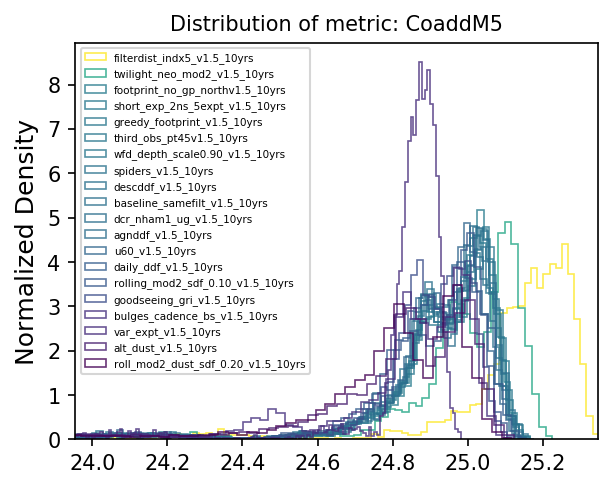

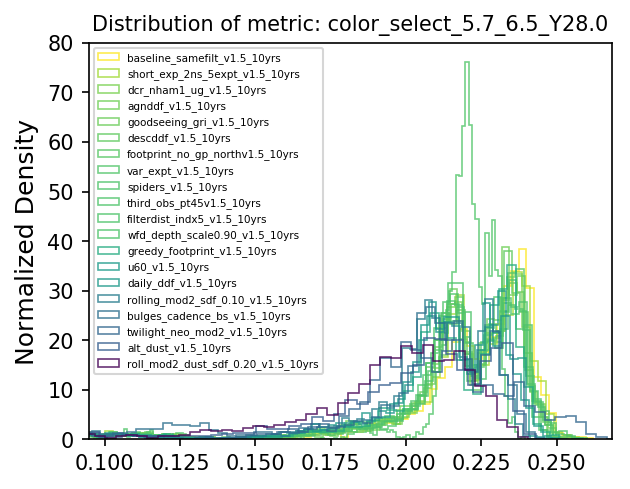

In [24]:
# loop though each metric to make plots, since some values are fairly large 
# and built in functions doesn't allow log scale

# options to provide same xlim for all metric plots
# provide a number if you want uniform xlim for all plots
xMax = None    # Set to value or None
xMin = None  # Set to value or None

# whether to save as PNGs
savefig = False

for key in bd_keys:
#     if key[1].split('_')[-1] == 'g':
        
        # get the median of metric distribution for assigning colors
        unsorted_mds = get_metric_medians(key, bundleDicts, get_median)
        sort_order = np.argsort(unsorted_mds)
        sorted_mds = np.sort(unsorted_mds)
        Norm = mpl.colors.Normalize(vmin=sorted_mds[0], vmax=sorted_mds[-1])
        runs = list(resultDbsView.keys())
        
        # placeholder for metric max and min, will used to assign plotting limit
        xmax = []
        xmin = []       
        fig = plt.figure(dpi=150, figsize=(4.5, 3.5))
#         for i, run in enumerate(resultDbsView):
        for order in sort_order[::-1]:

            # get run_name
            run = runs[order]
            
            # look for the correct combination of metricID and metricName 
            keys = [*bundleDicts[run].keys()]
            metricKey = [elem for elem in keys if elem[1] == key[1]][0]

            # need to mask the pixels that have no available data & exclude nan/inf if exists
            mask = bundleDicts[run][metricKey].metricValues.mask
            data = bundleDicts[run][metricKey].metricValues.data[~mask]
            data = data[~(np.isnan(data) | np.isinf(data))]
            log10Data = np.copy(data)
            # plot
            _ = plt.hist(log10Data, bins='fd', histtype='step', alpha=0.8, linewidth=0.8,
                         color=mpl.cm.viridis(Norm(np.median(log10Data))), density=True, label=f'{run}')
#             plt.xlabel('Selection Completeness', fontsize=12)
            plt.ylabel('Normalized Density', fontsize=12)
            plt.legend(fontsize=5, loc=2)
            xmax.append(np.percentile(log10Data, 99.99))
            xmin.append(np.percentile(log10Data, 5))
            
        # check if uniform xlim provided
        if xMax is not None:
            plt.xlim(right=xMax)
        else:
            plt.xlim(right = np.max(xmax))
        
        if xMin is not None:
            plt.xlim(left=xMin)
        else:
            plt.xlim(left=np.min(xmin))

        plt.title(f'Distribution of metric: {key[1]}', fontsize=10)
        # options to save
        if savefig:
            plt.savefig(f'Distribution of metric {key[1]}.png', dpi=200)

#### 3.3 Compare the color_select_metric summary statistics: 10, 50 and 90 percentiles

In [25]:
stat_names = getSummaryStatNames(resultDbsView[dbRuns[0]], bd_keys[1][1])
print(stat_names)

[{'metricId': 2, 'StatNames': ['10th%ile', '90th%ile', 'Median']}]


In [26]:
summary_df_10p = getSummary(resultDbsView, bd_keys[1][1], '10th%ile').sort_values('summaryValue', ascending=False)
summary_df_50p = getSummary(resultDbsView, bd_keys[1][1], 'Median').sort_values('summaryValue', ascending=False)
summary_df_90p = getSummary(resultDbsView, bd_keys[1][1], '90th%ile').sort_values('summaryValue', ascending=False)

In [27]:
summary_df_10p

,metricId,metricName,slicerName,metricMetadata,summaryName,summaryValue,runName
18,1,color_select_5.7_6.5_Y28.0,HealpixSlicer,proposalId 1 and note not like DD%,10th%ile,0.208946,var_expt_v1.5_10yrs
2,2,color_select_5.7_6.5_Y28.0,HealpixSlicer,proposalId 1 and note not like DD%,10th%ile,0.194853,baseline_samefilt_v1.5_10yrs
7,2,color_select_5.7_6.5_Y28.0,HealpixSlicer,proposalId 1 and note not like DD%,10th%ile,0.193423,filterdist_indx5_v1.5_10yrs
9,2,color_select_5.7_6.5_Y28.0,HealpixSlicer,proposalId 1 and note not like DD%,10th%ile,0.191789,goodseeing_gri_v1.5_10yrs
5,1,color_select_5.7_6.5_Y28.0,HealpixSlicer,proposalId 1 and note not like DD%,10th%ile,0.190564,dcr_nham1_ug_v1.5_10yrs
13,2,color_select_5.7_6.5_Y28.0,HealpixSlicer,proposalId 1 and note not like DD%,10th%ile,0.189951,short_exp_2ns_5expt_v1.5_10yrs
15,1,color_select_5.7_6.5_Y28.0,HealpixSlicer,proposalId 1 and note not like DD%,10th%ile,0.189134,third_obs_pt45v1.5_10yrs
6,1,color_select_5.7_6.5_Y28.0,HealpixSlicer,proposalId 1 and note not like DD%,10th%ile,0.188930,descddf_v1.5_10yrs
19,2,color_select_5.7_6.5_Y28.0,HealpixSlicer,proposalId 1 and note not like DD%,10th%ile,0.187847,wfd_depth_scale0.90_v1.5_10yrs
14,1,color_select_5.7_6.5_Y28.0,HealpixSlicer,proposalId 1 and note not like DD%,10th%ile,0.187704,spiders_v1.5_10yrs


In [28]:
summary_df_50p

,metricId,metricName,slicerName,metricMetadata,summaryName,summaryValue,runName
2,2,color_select_5.7_6.5_Y28.0,HealpixSlicer,proposalId 1 and note not like DD%,Median,0.228350,baseline_samefilt_v1.5_10yrs
13,2,color_select_5.7_6.5_Y28.0,HealpixSlicer,proposalId 1 and note not like DD%,Median,0.224265,short_exp_2ns_5expt_v1.5_10yrs
5,1,color_select_5.7_6.5_Y28.0,HealpixSlicer,proposalId 1 and note not like DD%,Median,0.222426,dcr_nham1_ug_v1.5_10yrs
0,2,color_select_5.7_6.5_Y28.0,HealpixSlicer,proposalId 1 and note not like DD%,Median,0.222018,agnddf_v1.5_10yrs
9,2,color_select_5.7_6.5_Y28.0,HealpixSlicer,proposalId 1 and note not like DD%,Median,0.221814,goodseeing_gri_v1.5_10yrs
6,1,color_select_5.7_6.5_Y28.0,HealpixSlicer,proposalId 1 and note not like DD%,Median,0.221201,descddf_v1.5_10yrs
8,1,color_select_5.7_6.5_Y28.0,HealpixSlicer,proposalId 1 and note not like DD%,Median,0.220792,footprint_no_gp_northv1.5_10yrs
18,1,color_select_5.7_6.5_Y28.0,HealpixSlicer,proposalId 1 and note not like DD%,Median,0.220384,var_expt_v1.5_10yrs
15,1,color_select_5.7_6.5_Y28.0,HealpixSlicer,proposalId 1 and note not like DD%,Median,0.220180,third_obs_pt45v1.5_10yrs
14,1,color_select_5.7_6.5_Y28.0,HealpixSlicer,proposalId 1 and note not like DD%,Median,0.220180,spiders_v1.5_10yrs


In [29]:
summary_df_90p

,metricId,metricName,slicerName,metricMetadata,summaryName,summaryValue,runName
2,2,color_select_5.7_6.5_Y28.0,HealpixSlicer,proposalId 1 and note not like DD%,90th%ile,0.241217,baseline_samefilt_v1.5_10yrs
13,2,color_select_5.7_6.5_Y28.0,HealpixSlicer,proposalId 1 and note not like DD%,90th%ile,0.241013,short_exp_2ns_5expt_v1.5_10yrs
16,1,color_select_5.7_6.5_Y28.0,HealpixSlicer,proposalId 1 and note not like DD%,90th%ile,0.239992,twilight_neo_mod2_v1.5_10yrs
15,1,color_select_5.7_6.5_Y28.0,HealpixSlicer,proposalId 1 and note not like DD%,90th%ile,0.239175,third_obs_pt45v1.5_10yrs
19,2,color_select_5.7_6.5_Y28.0,HealpixSlicer,proposalId 1 and note not like DD%,90th%ile,0.238971,wfd_depth_scale0.90_v1.5_10yrs
5,1,color_select_5.7_6.5_Y28.0,HealpixSlicer,proposalId 1 and note not like DD%,90th%ile,0.238971,dcr_nham1_ug_v1.5_10yrs
14,1,color_select_5.7_6.5_Y28.0,HealpixSlicer,proposalId 1 and note not like DD%,90th%ile,0.238766,spiders_v1.5_10yrs
0,2,color_select_5.7_6.5_Y28.0,HealpixSlicer,proposalId 1 and note not like DD%,90th%ile,0.238766,agnddf_v1.5_10yrs
8,1,color_select_5.7_6.5_Y28.0,HealpixSlicer,proposalId 1 and note not like DD%,90th%ile,0.238562,footprint_no_gp_northv1.5_10yrs
9,2,color_select_5.7_6.5_Y28.0,HealpixSlicer,proposalId 1 and note not like DD%,90th%ile,0.238562,goodseeing_gri_v1.5_10yrs


#### 3.4 SkyPlots
Show the selection completeness metric over the sky

<!-- __WY:__ Didn't find a easy way to plot healpy plot side by side, healpy takes figure as input, not axes. 
Might find better ways in the future -->

In [30]:
# function to make sky plot
import healpy as hp
import healpy as hp
def plotSky_scale(mb, scale_func=np.log10, minVal=None, maxVal=None, **kwargs):
    '''
    Plot skymap. 
    Args:
        mb: MetricBundle object.
        scale_func (func): A scaling function for the metric data, e.g., np.log10
        minVal (float): Mininum value to plot
        maxVal (float): Maximum value to plot
    '''
    try:
        # take the data, scale it by the scale_func, then assign it back
        mbValues = mb.metricValues.copy()
        mask = mbValues.mask
        data = mbValues.data[~mask]
        nData = scale_func(data)
        mbValues.data[~mask] = nData
    except Exception as e:
        print(e)
        return None
    
    if maxVal is None:
        maxVal = np.percentile(nData, 99.99)
    if minVal is None: 
        minVal = np.percentile(nData, 0.01)
        
    _ = hp.mollview(mbValues, flip='astro', max=maxVal, min=minVal, **kwargs)
    _ = hp.graticule(dpar=30, dmer=30, verbose=False)
    plt.title(f'Metric:{mb.metric.name}, RunName:{mb.runName}', fontsize=15)

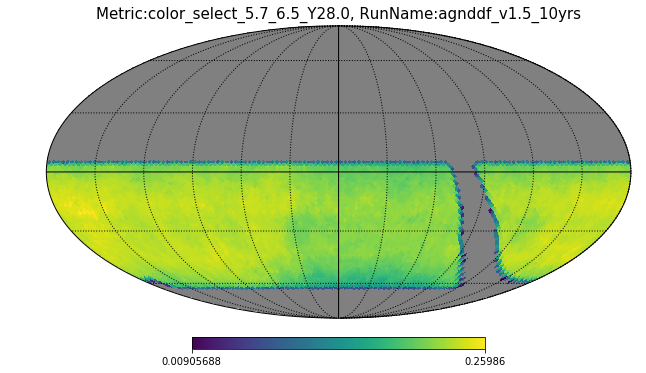

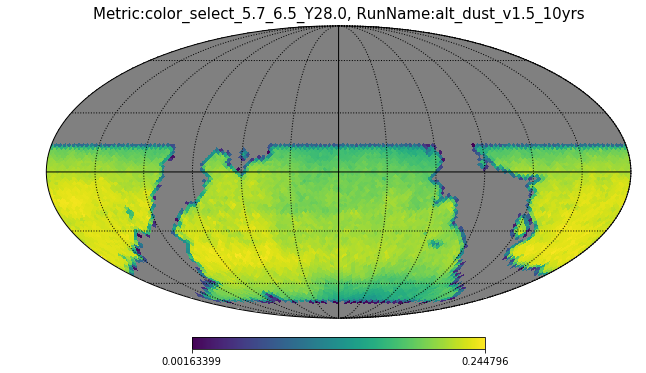

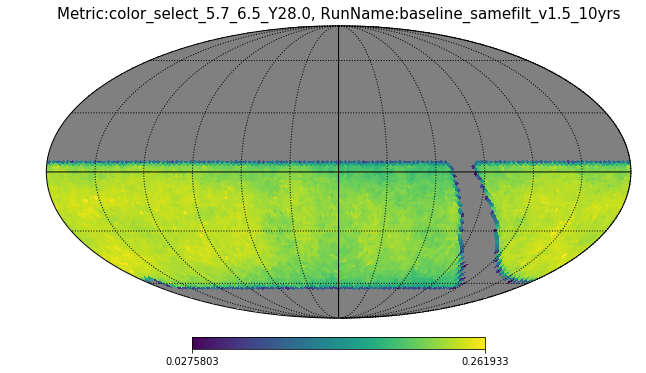

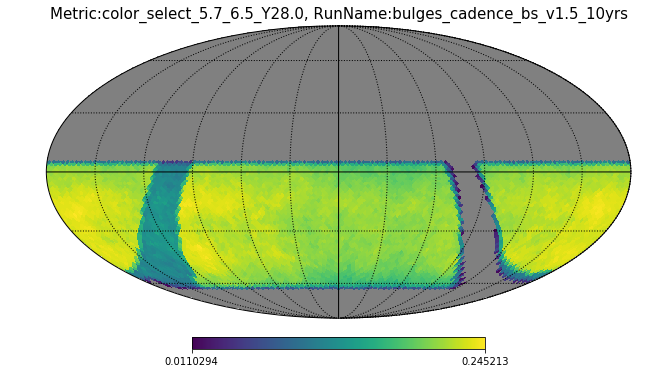

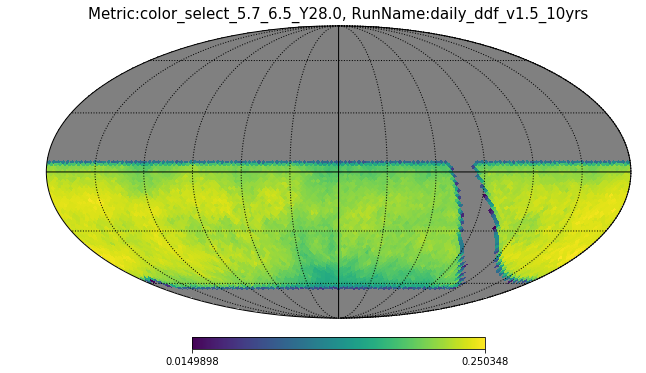

In [31]:
# only plotting first few opsims to save space
for k, run in enumerate(resultDbsView):
    if k < 5: # Make smaller to only plot a few examples
        
        # get the metricKey
        key = bd_keys[1]

        # look for the correct combination of metricID and metricName 
        keys = [*bundleDicts[run].keys()]
        metricKeyG = [elem for elem in keys if elem[1] == key[1]][0]
        plotSky_scale(bundleDicts[run][metricKeyG], np.copy, maxVal=None, minVal=None) # color bar changes for each plot
#         plotSky_scale(bundleDicts[run][metricKeyG], np.log, maxVal=-4.5, minVal=-6.5) # color bar fixed

### -----Stop Here----------